In [75]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
x_train=mnist.train.images[0:50].reshape(50,28,28,1)
y_train=(mnist.train.labels[0:50]).T

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Batch normalization

In [101]:
def batch_forward(Z,gamma,beta,epsilon=0.001):
    m=Z.shape[1]
    Z_mu=np.mean(Z,axis=1,keepdims=True)
    var=1.0/m*np.sum((Z-Z_mu)**2,axis=1,keepdims=True)
    inv_var=1.0/np.sqrt(var+epsilon)
    Z_hat=(Z-Z_mu)*np.sqrt(1.0/inv_var+0.001)
    Z_telda=gamma*Z_hat+beta
    cache2=Z_mu, inv_var, Z_hat, gamma 
    return Z_telda,cache2

### CNN_forward

In [102]:
def cnn_forward(A_prev,W,b,f,f_num,pad,s,activation="relu"):
    A_prev_pad=np.pad(A_prev,((0,0),(pad,pad),(pad,pad),(0,0)),"constant",constant_values=0)
    (m,n_h,n_w,n_c)=A_prev_pad.shape
    n_h=int((n_h-f-2*pad+1)/s)+1
    n_w=int((n_w-f-2*pad+1)/s)+1
    n_c=f_num
    Z=np.zeros((m,n_h,n_w,n_c))
    for i in range(m):
        for h in range(n_h):
            for w in range(n_w):
                for c in range(n_c):
                    Z[i,h,w,c]=np.sum(A_prev_pad[i,h*s:h*s+f,w*s:w*s+f,:]*W[:,:,:,c])+b[:,:,:,c]
    if(activation=="relu"):
        A=np.maximum(0,Z)
    if(activation=="sigmoid"):
        A=1.0/(1.0+np.exp(-Z))
    cache=(A_prev,W,b,Z,A,s,f,pad,activation)
    return A, cache

### Pooling_forward

In [103]:
def pooling_forward(A_prev,f,s,pooling="max"):
    (m,n_h,n_w,n_c)=A_prev.shape
    n_h=int((n_h-f+1)/s)+1
    n_w=int((n_w-f+1)/s)+1
    A=np.zeros((m,n_h,n_w,n_c))
    for i in range(m):
        for h in range(n_h):
            for w in range(n_w):
                for c in range(n_c):
                    if(pooling=="max"):
                        A[i,h,w,c]=np.max(A_prev[i,h*s:h*s+f,w*s:w*s+f,c])
                    if(pooling=="average"):
                        A[i,h,w,c]=np.mean(A_prev[i,h*s:h*s+f,w*s:w*s+f,c])
    cache=(A_prev,f,s,A,pooling)    
    return A,cache

### Reshaping_layer

In [104]:
def reshape(A):
    (m,n_h,n_w,n_c)=A.shape
    return A.reshape(m,n_h*n_w*n_c).T

### FC_forward

In [105]:
def fc_forward(A_prev,W,b,gamma,beta,n_h,activation="relu",initialize="yes"):
    (n_x,m)=A_prev.shape
    Z=np.dot(W,A_prev)+b
    Z_telda,cache2=batch_forward(Z,gamma,beta)
    if(activation=="relu"):
        A=np.maximum(0,Z_telda)
    if(activation=="sigmoid"):
        A=1.0/(1.0+np.exp(-Z_telda))
    if(activation=="softmax"):
        exp_Z=np.exp(Z_telda-np.max(Z_telda))
        A=(exp_Z)/exp_Z.sum()
    cache=(A_prev,W,b,A,Z_telda)
    return A, cache, cache2

### FC_backward

In [106]:
def fc_backward(dA,cache,cache2,activation="relu"):
    A_prev,W,b,Z_telda,A=cache
    Z_mu, inv_var, Z_hat, gamma = cache2
    m=A_prev.shape[0]
    if(activation=="relu"):
        dZ_telda = np.array(dA, copy=True) 
        dZ_telda[Z_telda <= 0] = 0
    if(activation=="sigmoid"):
        gradient=(A*(1-A))
        dZ_telda=dA*gradient
    if(activation=="softmax"):
        dZ_telda=dA 
        
    dZhat = dZ_telda * gamma
    dZ=(1.0 / m) * inv_var * (m*dZhat - np.sum(dZhat, axis=1,keepdims=True) - Z_hat*np.sum(dZhat*Z_hat, axis=1,keepdims=True))
    dA_prev=np.dot(W.T,dZ)
    dW=1.0/m*(np.dot(dZ,A_prev.T))
    db=1.0/m*(np.sum(dZ,axis=1,keepdims=True))
    dgamma=1.0/m*np.sum(Z_hat*dZ_telda, axis=1,keepdims=True)
    dbeta=1.0/m*np.sum(dZ_telda, axis=1,keepdims=True)
    return dA_prev, dW, db ,dgamma, dbeta

### Pooling_backward

In [107]:
def pooling_backward(dA,cache):
    A_prev,f,s,A,pooling=cache
    (m,n_h,n_w,n_c)=A_prev.shape
    dA_prev=np.zeros((m,n_h,n_w,n_c))
    (m,n_h,n_w,n_c)=dA.shape
    for i in range(m):
        for h in range(n_h):
            for w in range(n_w):
                for c in range(n_c):
                    if(pooling=="max"):
                        mask=(A_prev[i,h*s:h*s+f,w*s:w*s+f,c]==np.max(A_prev[i,h*s:h*s+f,w*s:w*s+f,c]))
                        dA_prev[i,h*s:h*s+f,w*s:w*s+f,c]+=mask*dA[i,h,w,c]
                    if(pooling=="average"):
                        dA_prev[i,h*s:h*s+f,w*s:w*s+f,c]+=1.0/(f*f)*dA[i,h,w,c]
    return dA_prev

### cnn_backward

In [108]:
def cnn_backward(dA,cache):
    A_prev,W,b,Z,A,s,f,pad,activation=cache
    A_prev_pad=np.pad(A_prev,((0,0),(pad,pad),(pad,pad),(0,0)),"constant",constant_values=0)
    dA_prev=np.zeros(A_prev_pad.shape)
    dW=np.zeros(W.shape)
    db=np.zeros(b.shape)
    if (activation=="relu"):
        gradient=Z[Z<=0]=0
    if(activation=="sigmoid"):
        gradient=A*(1-A)
    dZ=dA*gradient
    m,n_h,n_w,n_c=dZ.shape
    for i in range(m):
        for h in range(n_h):
            for w in range(n_w):
                for c in range(n_c):
                    dA_prev[i,h*s:h*s+f,w*s:w*s+f,:]+=W[:,:,:,c]*dZ[i,h,w,c]
                    dW[:,:,:,c]+=A_prev_pad[i,h*s:h*s+f,w*s:w*s+f,:]*dZ[i,h,w,c]
                    db[:,:,:,c]+=dZ[i,h,w,c]
    return dA_prev, dW,db

In [109]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = 1.0/m*(np.sum(-np.log(AL+0.001)*y_train,keepdims=True))[0][0]
    return cost

In [110]:
A_0=x_train
W_1=np.random.randn(3,3,1,5)*0.01
b_1=np.random.randn(1,1,1,5)*0.01
W_3=np.random.randn(120,245)*0.01
b_3=np.random.randn(120,1)*0.01
W_4=np.random.randn(10,120)*0.01
b_4=np.random.randn(10,1)*0.01
A_1,cache_1 = cnn_forward(A_0,W_1,b_1,f=3,f_num=5,pad=2,s=2,activation="relu")
A_2, cache_2 = pooling_forward(A_1,f=2,s=2, pooling = "max")
A_2= reshape(A_2)
gamma_3=np.random.randn(120,1)
beta_3=np.random.randn(120,1)
gamma_4=np.random.randn(10,1)
beta_4=np.random.randn(10,1)
A_3,cache_3,cache2_3= fc_forward(A_2,W_3,b_3,gamma_3,beta_3,n_h=120, activation="relu")
A_4,cache_4, cache2_4= fc_forward(A_3,W_4,b_4,gamma_4,beta_4,n_h=10, activation="softmax")
costs=[]
temp_cost=compute_cost(A_4,y_train)
print("cost",temp_cost)
costs.append(temp_cost)
dZ_telda_4=A_4-y_train
dA_3, dW_4, db_4, dgamma_4, dbeta_4=fc_backward(dZ_telda_4,cache_4,cache2_4,activation="softmax")
dA_2, dW_3, db_3, dgamma_3, dbeta_3=fc_backward(dA_3,cache_3,cache2_3,activation="relu")
dA_2=dA_2.T
dA_2=dA_2.reshape(50,7,7,5)
dA_1 =pooling_backward(dA_2,cache_2)
dA_0,dW_1, db_1=cnn_backward(dA_1,cache_1)

('cost', 5.8708197148209615)


In [111]:
learning_rate=0.0001
for i in range(10):
    W_1=W_1-learning_rate*dW_1
    W_3=W_3-learning_rate*dW_3
    W_4=W_4-learning_rate*dW_4
    b_1=b_1-learning_rate*db_1
    b_3=b_3-learning_rate*db_3
    b_4=b_4-learning_rate*db_4
    gamma_3=gamma_3-learning_rate*dgamma_3
    gamma_4=gamma_4-learning_rate*dgamma_4
    beta_3=beta_3-learning_rate*dbeta_3
    beta_4=beta_4-learning_rate*dbeta_4
    A_1,cache_1 = cnn_forward(A_0,W_1,b_1,f=3,f_num=5,pad=2,s=2,activation="relu")
    A_2, cache_2 = pooling_forward(A_1,f=2,s=2, pooling = "max")
    A_2= reshape(A_2)
    A_3,cache_3,cache2_3= fc_forward(A_2,W_3,b_3,gamma_3,beta_3,n_h=120, activation="relu")
    A_4,cache_4, cache2_4= fc_forward(A_3,W_4,b_4,gamma_4,beta_4,n_h=10, activation="softmax")
    cost=compute_cost(A_4, y_train)
    costs.append(cost)
    change=temp_cost-cost
    temp_cost=cost
    print("{} epoch completed and cost is {}".format(i+1,cost))
    dZ_telda_4=A_4-y_train
    dA_3, dW_4, db_4, dgamma_4, dbeta_4=fc_backward(dZ_telda_4,cache_4,cache2_4,activation="softmax")
    dA_2, dW_3, db_3, dgamma_3, dbeta_3=fc_backward(dA_3,cache_3,cache2_3,activation="relu")
    dA_2=dA_2.T
    dA_2=dA_2.reshape(50,7,7,5)
    dA_1 =pooling_backward(dA_2,cache_2)
    dA_0,dW_1, db_1=cnn_backward(dA_1,cache_1)

1 epoch completed and cost is 5.8708194952
2 epoch completed and cost is 5.87081927558
3 epoch completed and cost is 5.87081905596
4 epoch completed and cost is 5.87081883634
5 epoch completed and cost is 5.87081861671
6 epoch completed and cost is 5.87081839709
7 epoch completed and cost is 5.87081817746
8 epoch completed and cost is 5.87081795782
9 epoch completed and cost is 5.87081773818
10 epoch completed and cost is 5.87081751853


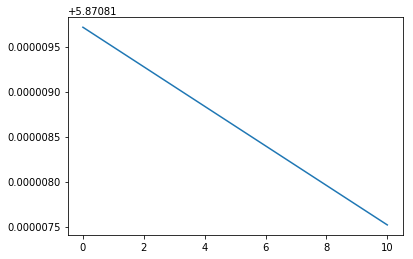

In [112]:
import matplotlib.pyplot as plt
plt.plot(costs)
plt.show()